In [27]:
# CELDA 1 — Imports y configuración
import os
import warnings
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Rutas (ajusta si tu proyecto está en otra estructura)
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
CLUSTER_DIR = os.path.join(PROCESSED_DIR, "clustering")
PLOTS_DIR = os.path.join(CLUSTER_DIR, "plots")

os.makedirs(CLUSTER_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print("Resultados de clustering se guardarán en:", CLUSTER_DIR)


Resultados de clustering se guardarán en: d:\Projects\University-Projects\AlphaTech-Analyzer\data\processed\clustering


In [28]:
# CELDA 2 — Cargar agregados (agg_df) desde CSV si no está en memoria
if 'agg_df' not in globals():
    agg_path = os.path.join(PROCESSED_DIR, "tech30_aggregated_stats_2018_2024.csv")
    if not os.path.exists(agg_path):
        raise FileNotFoundError(f"No se encontró {agg_path}. Ejecuta antes el pipeline que crea agg_df.")
    agg_df = pd.read_csv(agg_path)

print("agg_df cargado:", agg_df.shape)
agg_df.head()


agg_df cargado: (30, 9)


,Company,Ticker,MeanReturn,Volatility,Beta,AvgVolume,N_months,logAvgVolume,Cluster
0,ASML,ASML,0.015685,0.096761,1.272729,2.083840e+07,83,16.852308,2
1,Accenture,ACN,0.010715,0.072160,0.989995,4.702290e+07,83,17.666145,2
2,Adobe,ADBE,0.009672,0.095036,1.187009,6.403960e+07,83,17.975012,2
3,Alphabet,GOOGL,0.014190,0.072604,0.930717,7.089949e+08,83,20.379359,0
4,Amazon,AMZN,0.013438,0.089370,1.245651,1.591051e+09,83,21.187661,0


In [29]:
# CELDA 2 — Cargar agregados (agg_df) desde CSV si no está en memoria
if 'agg_df' not in globals():
    agg_path = os.path.join(PROCESSED_DIR, "tech30_aggregated_stats_2018_2024.csv")
    if not os.path.exists(agg_path):
        raise FileNotFoundError(f"No se encontró {agg_path}. Ejecuta antes el pipeline que crea agg_df.")
    agg_df = pd.read_csv(agg_path)

print("agg_df cargado:", agg_df.shape)
agg_df.head()


agg_df cargado: (30, 9)


,Company,Ticker,MeanReturn,Volatility,Beta,AvgVolume,N_months,logAvgVolume,Cluster
0,ASML,ASML,0.015685,0.096761,1.272729,2.083840e+07,83,16.852308,2
1,Accenture,ACN,0.010715,0.072160,0.989995,4.702290e+07,83,17.666145,2
2,Adobe,ADBE,0.009672,0.095036,1.187009,6.403960e+07,83,17.975012,2
3,Alphabet,GOOGL,0.014190,0.072604,0.930717,7.089949e+08,83,20.379359,0
4,Amazon,AMZN,0.013438,0.089370,1.245651,1.591051e+09,83,21.187661,0


In [30]:
# CELDA 4 — Escalado de variables
# Transformación: log(AvgVolume) mejora escala y reduce sesgo
agg_df["logAvgVolume"] = np.log(agg_df["AvgVolume"].replace(0, np.nan)).fillna(0)

features = ["MeanReturn","Volatility","Beta","logAvgVolume"]
X = agg_df[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Guardar scaler params (opcional)
scaler_info = {
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist(),
    "features": features
}
with open(os.path.join(CLUSTER_DIR, "scaler_info.json"), "w") as f:
    json.dump(scaler_info, f, indent=2)


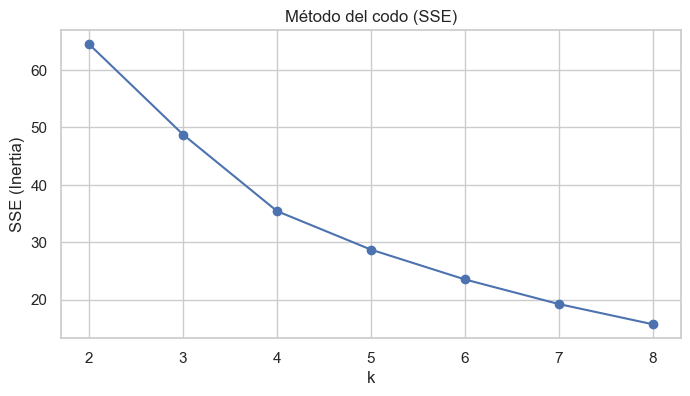

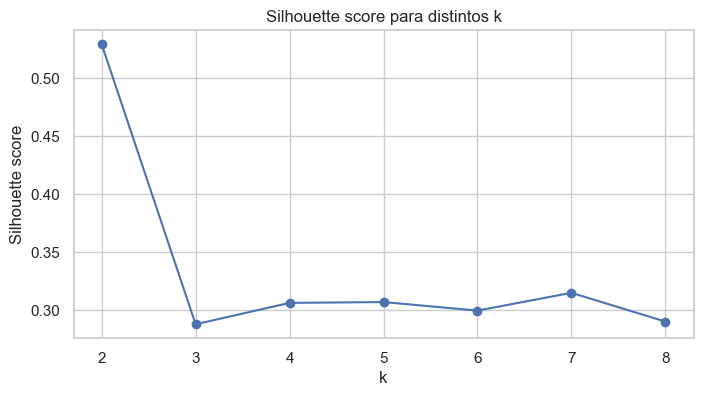

SSE y silhouette guardados. Revisa plots para escoger k.


In [31]:
# CELDA 5 — Método del codo (SSE) y silhouette
sse = []
sil_scores = []
ks = list(range(2, 9))

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sse.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot SSE (elbow)
plt.figure(figsize=(8,4))
plt.plot(ks, sse, '-o')
plt.xlabel("k")
plt.ylabel("SSE (Inertia)")
plt.title("Método del codo (SSE)")
plt.xticks(ks)
plt.grid(True)
plt.savefig(os.path.join(PLOTS_DIR, "elbow_sse.png"), dpi=150)
plt.show()

# Plot silhouette
plt.figure(figsize=(8,4))
plt.plot(ks, sil_scores, '-o')
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("Silhouette score para distintos k")
plt.xticks(ks)
plt.grid(True)
plt.savefig(os.path.join(PLOTS_DIR, "silhouette_scores.png"), dpi=150)
plt.show()

# Guardar valores
pd.DataFrame({"k": ks, "sse": sse, "silhouette": sil_scores}).to_csv(
    os.path.join(CLUSTER_DIR, "cluster_selection_metrics.csv"), index=False
)

print("SSE y silhouette guardados. Revisa plots para escoger k.")


In [32]:
# CELDA 6 — Ajustar KMeans final
k_final = 3   # <- cámbialo si la celda anterior te sugiere otro k

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=50)
labels = kmeans.fit_predict(X_scaled)

agg_df["Cluster"] = labels
agg_df["Cluster"] = agg_df["Cluster"].astype(int)

# Guardar modelo outputs básicos
pd.DataFrame({
    "Company": agg_df["Company"],
    "Cluster": agg_df["Cluster"]
}).to_csv(os.path.join(CLUSTER_DIR, "agg_with_clusters.csv"), index=False)

# Centroides (en escala original)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=features)
centroids_df["Cluster"] = range(k_final)
centroids_df.to_csv(os.path.join(CLUSTER_DIR, "cluster_centroids.csv"), index=False)

print(f"KMeans ajustado con k={k_final}. Resultados guardados.")
centroids_df


KMeans ajustado con k=3. Resultados guardados.


,MeanReturn,Volatility,Beta,logAvgVolume,Cluster
0,0.013732,0.087878,0.904007,19.822954,0
1,0.037751,0.192537,1.973352,21.856141,1
2,0.011218,0.110558,1.169404,17.766361,2


In [33]:
# CELDA 7 — Resumen por cluster
cluster_summary = agg_df.groupby("Cluster")[
    ["MeanReturn","Volatility","Beta","AvgVolume"]
].agg(["mean","std","count"])

cluster_summary.to_csv(os.path.join(CLUSTER_DIR, "cluster_summary_stats.csv"))
print("Resumen por cluster guardado.")
cluster_summary


Resumen por cluster guardado.


MeanReturn                 Volatility                      Beta  \
              mean       std count       mean       std count      mean   
Cluster                                                                   
0         0.013732  0.009714    18   0.087878  0.017329    18  0.904007   
1         0.037751  0.003240     3   0.192537  0.053877     3  1.973352   
2         0.011218  0.009646     9   0.110558  0.033728     9  1.169404   

                            AvgVolume                      
              std count          mean           std count  
Cluster                                                    
0        0.246232    18  5.984290e+08  5.701371e+08    18  
1        0.146293     3  4.504311e+09  4.543190e+09     3  
2        0.213744     9  6.380449e+07  4.171012e+07     9

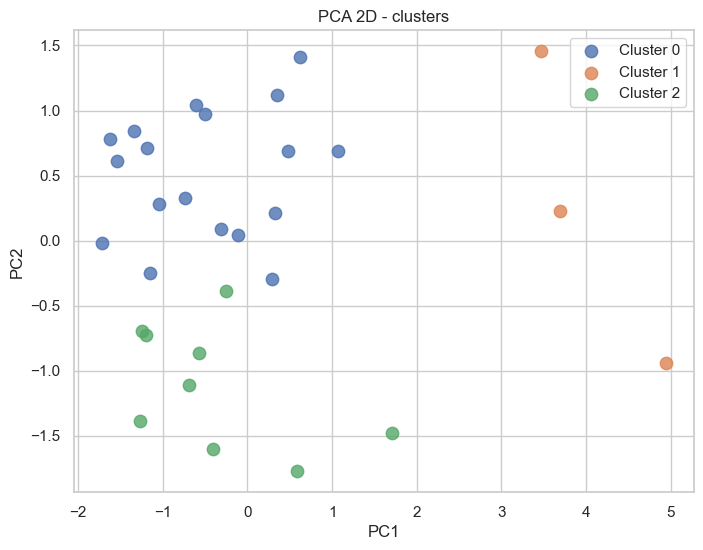

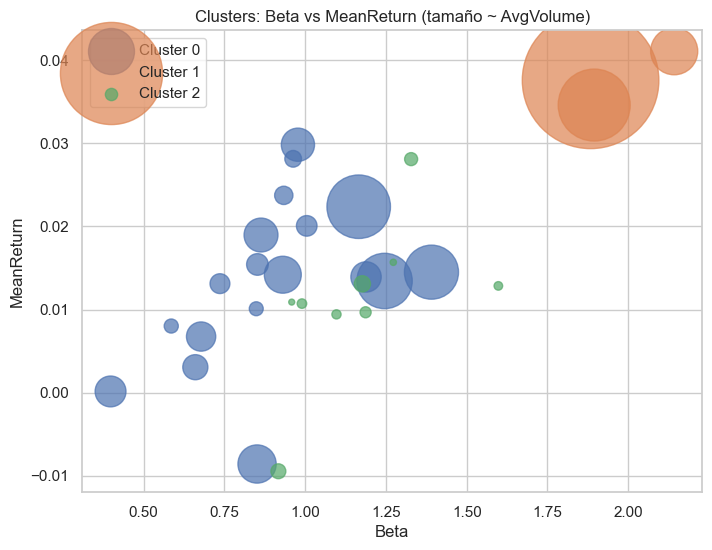

In [34]:
# CELDA 8 — Visualizaciones (PCA + scatter Beta vs MeanReturn)
# PCA 2D para ver clusters
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X_scaled)
agg_df["PC1"] = pc[:,0]
agg_df["PC2"] = pc[:,1]

plt.figure(figsize=(8,6))
for c in sorted(agg_df["Cluster"].unique()):
    sub = agg_df[agg_df["Cluster"]==c]
    plt.scatter(sub["PC1"], sub["PC2"], label=f"Cluster {c}", s=80, alpha=0.8)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA 2D - clusters")
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, "pca_clusters.png"), dpi=150)
plt.show()

# Scatter Beta vs MeanReturn (tamaño por AvgVolume)
plt.figure(figsize=(8,6))
for c in sorted(agg_df["Cluster"].unique()):
    sub = agg_df[agg_df["Cluster"]==c]
    plt.scatter(sub["Beta"], sub["MeanReturn"], s=(sub["AvgVolume"]/1e6), alpha=0.7, label=f"Cluster {c}")
plt.xlabel("Beta")
plt.ylabel("MeanReturn")
plt.title("Clusters: Beta vs MeanReturn (tamaño ~ AvgVolume)")
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, "beta_vs_meanreturn_clusters.png"), dpi=150)
plt.show()


In [35]:
# CELDA 9 — Guardar outputs finales
agg_df.to_csv(os.path.join(CLUSTER_DIR, "agg_with_clusters_full.csv"), index=False)

# Guardar summary legible para LaTeX / informe
cluster_summary_reset = cluster_summary.reset_index()
cluster_summary_reset.to_csv(os.path.join(CLUSTER_DIR, "cluster_summary_for_report.csv"), index=False)

# Guardar simple mapping company->cluster
pd.DataFrame({"Company": agg_df["Company"], "Cluster": agg_df["Cluster"]}).to_csv(
    os.path.join(CLUSTER_DIR, "company_cluster_map.csv"), index=False
)

print("✅ Todos los archivos de clustering guardados en:", CLUSTER_DIR)


✅ Todos los archivos de clustering guardados en: d:\Projects\University-Projects\AlphaTech-Analyzer\data\processed\clustering
